# Click Requests from a Single Campaign with Known BOT Activity


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from IPython.display import display

df = pd.read_csv('C:/Users/youci/Documents/SingleCampaignClicksWithKnownBotActivity.csv', 
                 parse_dates=['SendDate', 'RequestDate'],
                dtype = {'AS Number':str})  

# Clean up
df.fillna('Unknown', inplace=True)


# Calculated Columns
df['SendRequestLatency'] = df.RequestDate - df.SendDate
df['SendRequestSeconds'] = ((pd.to_datetime(df['RequestDate']) - 
                            pd.to_datetime(df['SendDate']))
                                .dt.total_seconds()).clip(lower=0).astype('int')

## Terminology
- **Subscriber List** - A list of email addresses that have opted into receiving emails from the company.  A list have have many emails.  A company can have many subscriber lists.  An email can belong to many lists and many companies.  But a subscriber list can only belong to one company.
- **Campaign** - An email message send out by a company.  This email is sent to some or all the subscribers on the list.  With the exception of some limited personalization, all subscribed receive the same content.  A list can have many campaigns, but a campaign can only have one subscriber list.
- **Inbox** - What the contact sees as a unique message in their inbox (Outlook, GMail, etc.).  If a company sends a single campaign to 1 million contacts, there will be 1 million InboxIDs for that campaign.
- **Request** - A tracking HTTP request from an action the contact takes on a message in their inbox.  There are several types of requests, but they are primarily Opens which are pixel image reqeusts and Clicks.
- **Link** - A clickable and trackable URL embedded in the email message.  The tracking system identifies the click, saved the tracking information and returns a redirect URL so the contact gets to their intended URL destination.
- **AS Number/Name** - Who owns the block of IP address.  https://en.wikipedia.org/wiki/Autonomous_system_(Internet)
- **CIDR** - A notation of shows us what range of IP address are in a block. https://en.wikipedia.org/wiki/Classless_Inter-Domain_Routing


## Columns
 - **Company** - Who owns the campaign
 - **InboxID** - Uniquely identifies the Campaign and the email it was sent to.
 - **RequestType** - 
     - *Open* - The contact downloaded images for the message.  A tracking pixel added to the HTML body of the message makes a request to the tracking system to identify who opened the message.
     - *Read* - The message was opened for a pre-defined period of time.
     - *Click* - The contact clicked on a URL in the message and the tracking system sees this request.
     - *Browser Link* - The contact requested seeing the message in a web browser.  Mostly used if the message did not render well in the email client.
 - **SendDate** - The date and time (1 minute precision) of when the message was sent to that email.  If a company sends a campaign to 5 million email, the send might take 10-20 mins.  The SendDate is the date when that message was sent out and not the date the campaign started.
 - **RequestDate** - The date of the reqeust (i.e. Open or Click).
 - **Link** - A hash of the URL requested.
 - **IPAddress** - The IP Address the requested was generated from.
 - **UserAgent** - A string submitted by email clients/browsers and Bots that attempts to identify the browser type.  This can be made any string you want to it can be easily modified by Bots.
 - **AS Name** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **AS Number** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **CIDR Range** - The block the IPAddress belongs to (see above).  Can be Null if owner not found in ASN database.
 - **UserID** - A unique ID of the email address the message was sent to.
 - **DomainID** - A unique ID of the domain of the email address the message was sent to.
 - **EmailDomain** (redundant with DomainID)- A unique ID of the domain of the email address the message was sent to.
 - **EmailRootLevelDomain** - The top level domain of the email domain.  i.e. fred@gamil.com - ".com", mary@harvard.edu - ".edu"
 - **List** - A unique ID of the subscription list.  
 - **Campaign** - A unique ID of the campaign.
 - **FirstActivityDate** - The first activity (Open, Click, etc.) that was received for a specific InboxID.  It is possible to have prior activity for the InboxID that is not captured in this dataset, but this is unlikely.
 - **FirstActivityDeviceType** - The type of device (phone, desktop) derived from parsing the User Agent.
 - **FirstActivityGeoLocationID** - A unique ID of the Geo Location the request came from derived from an IP Address lookup service.


## Sessionization

 Making assessments from individual requests may not be as informative as grouping requests together.  It is not uncommon for a single InboxID to have multiple requests. For example, 20 minutes after a message was put into a contact's inbox, they might open the message (pixel request) followed by 3 or 4 link clicks.  That same contact might go back to that same message the following day and click on several more links.
 
It might be more suspicious that requests are from a BOT if 20 clicks come in for the same InboxID in under 3 seconds or if the same IP Address requests opens from 50 different InboxIDs in a short period of time.

There are 3 things needed to determine a session.  The first is how to partition or group the data.  The more obvious choices for this grouping is the InboxID, the IP Address and the combination of both the IP and Inbox.

The next thing needed is the some kind of time frame algorithm.  The algorithm chosen is to include all requests for the given partition as long at duration between requests doesn't exceed a set gap. This requires a datetime column (in case, the RequestDate) and a max gap allowed.

The method below is structure in a way to allow us to use different partitioning column(s) and to append a "session ID" to the existing dataframe as opposed to showing a single session per row with aggregate data.

In [2]:
def get_session_column(df, group_column_1, datetime_column, time_gap, session_column, group_column_2 = None):
    """
    This method returns a pandas series that holds "session id"
    
    df = The dataframe we will based the session on
    group_column_1 = The column name will we use to partition the data on
    datatime_column = The datetime column name we will use as the basis of the session
    time_gap = How long between sorted requests need to elapse before we create a new session
    session_column = The name we will give to the new session column
    group_column_2 (Optional) = A second column name we can use to partition the data on
    
    1) Make sue passed in df is stored by the datatime column
    2) Copy the necessary columns into a working dataframe
    3) Add a column that shows the last previous datetime for the partitioned data (NaT if no previous row)
    4) Add a column that determines if the current row is a new session (NaT or too big a gap in time)
    5) Add a column that uses cumsum() to create a LocalSessionID scoped to the partition
    6) Add a column that uses a hash to get a global SessionID
    7) Return just the series.  
    
    Because we make sure the passed in dataframe is sorted, 
        the index of the returned series matches the index of the passed in dataframe
    """
    
    # The dataframe must be stored by RequestDate since we are window functions on this order 
    if not (df.index.name == datetime_column and df.index.is_monotonic()):
        df.sort_values(datetime_column, inplace=True)
        
    # set column names (this sorts the passed in dataframe)
    lastColumnName = 'Last' + datetime_column
    group = group_column_1
    if group_column_2:
        group = [group_column_1, group_column_2]
        
    # select local dataframe (allows us to work only on a subset of the full dataframe)
    if group_column_2:
        working_df = df[[group_column_1, datetime_column, group_column_2]].copy()
    else:
        working_df = df[[group_column_1, datetime_column]].copy()         
    

    # Create a pandas series (column) grouping by SendID that holds the previous RequestDate for that SendID
    last = working_df.groupby(group)[datetime_column].transform(lambda x:x.shift(1))

    # Append the above column to the dataframe with a name of LastRequestDate
    working_df = pd.concat([working_df, last.rename(lastColumnName)], axis=1)

    # It is a new session if LastRequestDate is null or the LastRequestDate is less then T old
    # We cast the result as an int so we can use cumsum in the next step
    working_df['IsNewSession'] = np.logical_or(working_df[datetime_column] - working_df[lastColumnName] > time_gap, 
                                       working_df[lastColumnName].isnull()).astype(int)

    # Use cumnsum to get the session number within a specific SendID. Note: This is not yet a global session id
    working_df['LocalSessionID'] = working_df.groupby(group)['IsNewSession'].cumsum()

    # New create a global session ID by combining the group by value and the LocalSessionID
    if group_column_2:
        working_df[session_column] = (
                                            working_df[group_column_1].astype(str) + '|' 
                                            + working_df[group_column_2].astype(str) + '|' 
                                            + working_df['LocalSessionID'].astype(str)
                                     ).apply(hash)
    else:
        working_df[session_column] =  (
                                            working_df[group_column_1].astype(str) + '|' 
                                            + working_df['LocalSessionID'].astype(str)
                                      ).apply(hash)
        
    return working_df[session_column]

## Extend Dataframe

Append 3 new columns to the df:
1. Partitioned by InboxID only - Same inbox message, but from any "computer".
2. Partitioned by IPAddress only - Same "computer", but from any inbox message.
3. Partitioned by InboxID and IPAddress - Same "computer" making reqeusts for the same message

_Note: "Computer" is used conceptually here.  It is possible that many different computers (i.e. people) can make requests on the same IP Address.  This is common where companies have use the same external IP address for all their employees._

In [3]:
# If there is a gap of more then 2 minutes, we will call it a new session    
time_gap = timedelta(seconds=120)

# Session based on just the InboxID
df = pd.concat([df, 
                get_session_column(df, 
                                 group_column_1='InboxID',  
                                 datetime_column='RequestDate', 
                                 time_gap=time_gap, 
                                 session_column='InboxSessionID')], 
                axis=1)

# Session based on just the IP Address
df = pd.concat([df, 
               get_session_column(df, 
                                group_column_1='IPAddress',
                                datetime_column='RequestDate', 
                                time_gap=time_gap, 
                                session_column='IPSessionID')], 
               axis=1)

# Session based on both the InboxID and IP Address
df = pd.concat([df, 
               get_session_column(df, 
                                group_column_1='InboxID',
                                group_column_2='IPAddress',
                                datetime_column='RequestDate', 
                                time_gap=time_gap, 
                                session_column='InboxIPSessionID')], 
               axis=1)

pd.options.display.max_columns = None
display(df) 

# Store the df for use in other workbooks
df_single_campaign_clicks_known_bot_activity = df
%store df_single_campaign_clicks_known_bot_activity

,Company,InboxID,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,List,Campaign,FirstActivityDate,FirstActivityDeviceType,FirstActivityGeoLocationID,SendRequestLatency,SendRequestSeconds,InboxSessionID,IPSessionID,InboxIPSessionID
0,{F79F612F-CBE8-13A6-0414-43E79B827E84},{C90AB8C5-66EE-F3A3-EAB0-63AC2361E15D},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{C017FA95-701E-1FEF-C6E3-32C4BB45E3E2},{EE7E123B-0826-0A3E-966E-567F2C44D752},{BF6C38B7-D032-EDC4-B147-5C68CFCAB5DC},"Amazon.com, Inc.",16509,{C6D5C5F4-81EF-0E9A-D63A-D6A0E1224F0A},{22D5B3ED-477A-AAB1-7458-BF48BFE5CD90},{D90FC163-D560-5A40-4503-A74BC49A063A},{BA8E1F7B-1AF0-8577-3062-E3E730FD093E},.org,{D696D55D-A688-F91C-80A6-5761835E00DC},{2854D052-60EE-8A54-2EA2-98C196C0C2E8},2020-01-17T09:03:00,2,{C8958ACA-91D5-8609-B032-4F5FC4EA7169},0 days 00:00:00,0,-1159395141605168714,1462024318548543399,5903971403891182174
71,{F79F612F-CBE8-13A6-0414-43E79B827E84},{EFD6D844-736A-1BA0-D254-50E057304399},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{CA14DFD1-AB95-1B7E-724A-04FD82E91EFB},{10A7D51F-F41C-31A9-05CF-AC6751F6591C},{BF6C38B7-D032-EDC4-B147-5C68CFCAB5DC},"Amazon.com, Inc.",16509,{D3E63AE6-F787-2ECC-B525-2DB961F09AFA},{DBF334FC-8868-5591-01EB-D2DB6BEDA2ED},{B200F962-E6AB-E0C3-E93B-206893F7F127},{A91F65A0-04EF-E24A-CBA8-DB7ED03A91B8},.us,{D696D55D-A688-F91C-80A6-5761835E00DC},{2854D052-60EE-8A54-2EA2-98C196C0C2E8},2020-01-17T09:03:00,2,{C8958ACA-91D5-8609-B032-4F5FC4EA7169},0 days 00:00:00,0,4024580775090890325,-786613611719407130,-4575087225629966465
91,{F79F612F-CBE8-13A6-0414-43E79B827E84},{F3BC6CA8-19F9-60D3-9B1F-2B0D60C4E542},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{EF9E5AD0-9665-C587-8F1E-C1AF3BFBD63E},{B31A2101-0371-8C50-8666-92CCC088355D},{BF6C38B7-D032-EDC4-B147-5C68CFCAB5DC},"Amazon.com, Inc.",16509,{293B86BE-B35F-382B-FE2F-D035DE428DC5},{4EF67274-2FE8-4924-7A87-4E6944934E4B},{006F481A-8DD0-7B23-1A57-A17B1EB25B04},{6633D0C1-5A1E-CC4D-3B8A-5CBF27B01C9C},.org,{D696D55D-A688-F91C-80A6-5761835E00DC},{2854D052-60EE-8A54-2EA2-98C196C0C2E8},2020-01-17T09:03:00,2,{C8958ACA-91D5-8609-B032-4F5FC4EA7169},0 days 00:00:00,0,-6810732052869290194,-6268699628889914714,432457910542413977
92,{F79F612F-CBE8-13A6-0414-43E79B827E84},{F3BC6CA8-19F9-60D3-9B1F-2B0D60C4E542},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{CA14DFD1-AB95-1B7E-724A-04FD82E91EFB},{6918DCA2-421D-F371-036D-44AE6E55BBF4},{BF6C38B7-D032-EDC4-B147-5C68CFCAB5DC},"Amazon.com, Inc.",16509,{5E1B9C83-FD80-E4FA-1AAB-606443865D0B},{4EF67274-2FE8-4924-7A87-4E6944934E4B},{006F481A-8DD0-7B23-1A57-A17B1EB25B04},{6633D0C1-5A1E-CC4D-3B8A-5CBF27B01C9C},.org,{D696D55D-A688-F91C-80A6-5761835E00DC},{2854D052-60EE-8A54-2EA2-98C196C0C2E8},2020-01-17T09:03:00,2,{C8958ACA-91D5-8609-B032-4F5FC4EA7169},0 days 00:00:00,0,-6810732052869290194,-4279696848000947284,-2238950361709899724
93,{F79F612F-CBE8-13A6-0414-43E79B827E84},{F3BC6CA8-19F9-60D3-9B1F-2B0D60C4E542},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{C017FA95-701E-1FEF-C6E3-32C4BB45E3E2},{D67321D1-E5DA-4A4D-D624-7F970998A8F5},{BF6C38B7-D032-EDC4-B147-5C68CFCAB5DC},"Amazon.com, Inc.",16509,{C6D5C5F4-81EF-0E9A-D63A-D6A0E1224F0A},{4EF67274-2FE8-4924-7A87-4E6944934E4B},{006F481A-8DD0-7B23-1A57-A17B1EB25B04},{6633D0C1-5A1E-CC4D-3B8A-5CBF27B01C9C},.org,{D696D55D-A688-F91C-80A6-5761835E00DC},{2854D052-60EE-8A54-2EA2-98C196C0C2E8},2020-01-17T09:03:00,2,{C8958ACA-91D5-8609-B032-4F5FC4EA7169},0 days 00:00:00,0,-6810732052869290194,-1000341321735162572,295912298880328116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24053,{F79F612F-CBE8-13A6-0414-43E79B827E84},{8432DD86-0441-0D67-EACB-486633389AB7},Click,2020-01-17 09:04:00,2020-01-21 11:12:00,{59AF873C-510F-D817-1C3C-7AC0DEA5BE3C},{09BE3EF4-78AB-3724-4264-2D5726BB950F},{D539965B-54D8-368F-4460-2BA3E69B861F},Unknown,Unknown,{347E150D-C2E3-0537-D56E-4B9BD225F811},{29990C70-EDCD-EA05-CC2E-6DA06AE715A

Stored 'df_single_campaign_clicks_known_bot_activity' (DataFrame)


## Only One Metrizable Column

Almost all the data in this dataset does not have any meaningful distance between data points.  In fact, most of the data is not even "class" data in the respect that the value is not some meaningful category but some kind of ID (degenerate dimension without meaning).  

The main feature we can use in some type of metric space is SendRequestSeconds.  How long after the message was sent to the contact did the contact perform an action (in this subset, we are only looking at Clicks).

#### Below are some histograms based on SendRequestSeconds

We might expect to see most Click requests come in sooner rather than later.  Less people click on links in an email after 2-3 days then people who click as soon as they receive the message in their inbox.  


<Figure size 432x288 with 0 Axes>

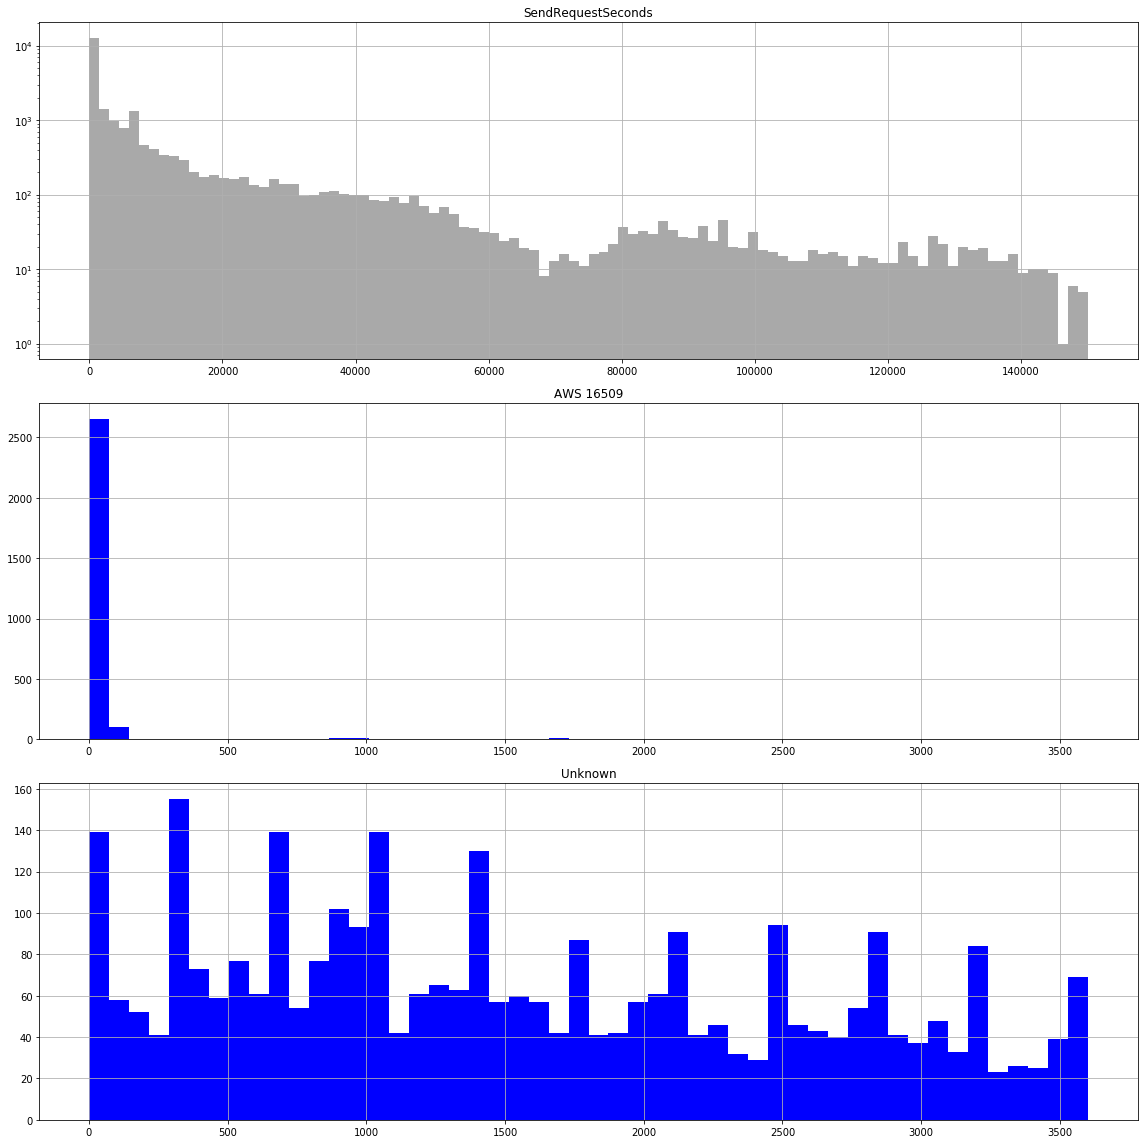

In [4]:
def SetHistoSubPlot(ax, X, bins=100, range=(1,10), ylog=False, color="blue", dfh=df, title=None):
    ax.hist(dfh[X], bins=bins, range=range, color=color)
    if not title:
        title = X
    ax.set_title(title)
    ax.grid(True)
    if ylog:
        ax.set_yscale('log')
    ax.tick_params('both')
    
# Histos    
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (16,16))

SetHistoSubPlot(ax[0], "SendRequestSeconds", bins=100, range=(0, 150000), ylog=True, color="darkgrey")

dfh = df[df['AS Number'] == '16509']
SetHistoSubPlot(ax[1], "SendRequestSeconds", bins=50, range=(2, 3600), dfh=dfh, title="AWS 16509")

dfh = df[df['AS Number'] == 'Unknown']
SetHistoSubPlot(ax[2], "SendRequestSeconds", bins=50, range=(2, 3600), dfh=dfh, title="Unknown")

plt.tight_layout()
plt.show()

# Use Aggregation to produce Metrizable Features

## Show aggregates by IP Owner (AS Name and Number)

#### Sort by the total requests descending (count of InboxID)

In [5]:
display(df.groupby(['AS Name', 'AS Number']).agg({
                                                   'UserAgent':'nunique', 
                                                   'Link':'nunique', 
                                                   'InboxSessionID':'nunique', 
                                                   'IPSessionID':'nunique', 
                                                   'InboxIPSessionID':'nunique', 
                                                   'SendRequestSeconds':['mean', 'std'], 
                                                   'InboxID':['nunique', 'count']
                                                    }) \
                             .sort_values([('InboxID','count')], ascending=False) \
                             .head(10)
       )

UserAgent  \
                                                               nunique   
AS Name                                            AS Number             
Unknown                                            Unknown        1010   
Amazon.com, Inc.                                   16509            19   
                                                   14618            22   
AT&T Mobility LLC                                  20057           180   
MCI Communications Services, Inc. Verizon Business 701              70   
T-Mobile USA, Inc.                                 21928            82   
Scalair SAS                                        206002           11   
CenturyLink Communications, LLC                    209              33   
Google LLC                                         15169            43   
Comcast Cable Communications, LLC                  7922             20   

                                                                Link  \
                                                             nunique   
AS Name                                            AS Number           
Unknown                                            Unknown        37   
Amazon.com, Inc.                                   16509          34   
                                                   14618          37   
AT&T Mobility LLC                                  20057          30   
MCI Communications Services, Inc. Verizon Business 701            27   
T-Mobile USA, Inc.                                 21928          27   
Scalair SAS                                        206002         34   
CenturyLink Communications, LLC                    209            26   
Google LLC                                         15169          36   
Comcast Cable Communications, LLC                  7922           17   

                                                             InboxSessionID  \
                                                                    nunique   
AS Name                                            AS Number                  
Unknown                                            Unknown             9073   
Amazon.com, Inc.                                   16509               1439   
                                                   14618                146   
AT&T Mobility LLC                                  20057                995   
MCI Communications Services, Inc. Verizon Business 701                  272   
T-Mobile USA, Inc.                                 21928                231   
Scalair SAS                                        206002                10   
CenturyLink Communications, LLC                    209                   83   
Google LLC                                         15169                 45   
Comcast Cable Communications, LLC                  7922                  70   

                                                             IPSessionID  \
                                                                 nunique   
AS Name                                            AS Number               
Unknown                                            Unknown          9466   
Amazon.com, Inc.                                   16509             115   
                                                   14618             100   
AT&T Mobility LLC                                  20057             998   
MCI Communications Services, Inc. Verizon Business 701               272   
T-Mobile USA, Inc.                                 21928             231   
Scalair SAS                                        206002              3   
CenturyLink Communications, LLC                    209                83   
Google LLC                                         15169              47   
Comcast Cable Communications, LLC                  7922               70   

                                                             InboxIPSessionID  \
                                                               

- **"Unknown"** - "Unknown" is expect to have the most requests.  The AS database is not fully populated so only the biggest owners of IPs will have an AS Name or Number.
- **Amazon (AWS)** - AWS has two datacenters, ASN16509 is in Oregon and ASN14618 is in Virginia.  

AWS can include any number of accounts. All the AWS ASN's are saying is that the requests are coming from an application hosted on AWS.

But compare Unknow to ASN16509.  Both have about the same number of total requests (InboxID/count).

Unknows has 1,010 unique user agent strings, but ASN16509 only has 19.  So, the 10k requests was only spread across 19 user agent string.  That is very suspicious.

Also look at the average time between the send and the request (SendRequestSeconds).  For Unknown, most requests come in after more then 8 hours after the send.  But for ASN16509, the aversage send to request time is only 7 minutes.

Another big difference is in the sessions.  Unknown shows that the unique count of sessions is about the same for IP/InboxID and Both.  But ASN16509 has a very low IPSessionID unique count.  This suggests that ASN16509 is reusing the same IP Address to hit many different SendIDs.

ASN16509 ratio of total requests/InboxID is high suggesting that most of the requests are asking for multiple clicks from the same message.  This ratio is much smaller for Unknown.